In [2]:
from thllib import flylib as flb
from matplotlib import pyplot as plt
import numpy as np
import scipy
from thllib import util
import figurefirst as fifi
import scipy.signal
import local_project_functions as lpf
from IPython.display import SVG,display

In [3]:
import networkx as nx

In [4]:
%matplotlib inline

In [5]:
flynumbers = list(range(1389,1402))
flylist = [flb.NetFly(fnum,rootpath='/media/imager/FlyDataD/FlyDB/') for fnum in flynumbers]
l = [fly.open_signals() for fly in flylist]
#fly = flylist[4]
#fly.open_signals()

/home/imager/.local/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in divide


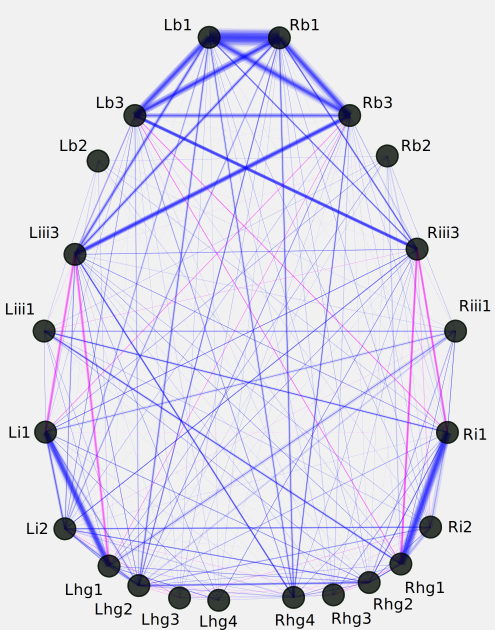

In [21]:
layout = fifi.FigureLayout('graph_layout.svg',make_mplfigures=True)

sorted_keys = sorted(fly.spikestates.keys())

cull_list = [('left', 'bkg'),('right', 'bkg'),
            ('left', 'iii24'),('right', 'iii24'),
            ('left', 'nm'),('right', 'nm'),
            ('left', 'pr'),('right', 'pr'),
            ('left', 'tpd'),('right', 'tpd')]

for cull in cull_list:
    sorted_keys.remove(cull)
#[sorted_keys.remove(cull) for cull in cull_list]

graphs = {}
for fly in flylist:
    state_mtrx = np.vstack([fly.spikestates[key] for key in sorted_keys])
    centered_mtrx = state_mtrx - np.mean(state_mtrx,axis = 1)[:,None]
    std_mtrx = centered_mtrx/np.std(centered_mtrx,axis = 1)[:,None]
    cor_mtrx = np.dot(std_mtrx,std_mtrx.T)
    G = nx.Graph()
    for i,lbl1 in enumerate(sorted_keys):
        for j,lbl2 in enumerate(sorted_keys):
            G.add_edge(lbl1,lbl2,weight = cor_mtrx[i,j])
    graphs[fly.flynum] = G

edges = G.edges
c_ex = layout.pathspecs['excitatory'].mplkwargs()['edgecolor']
c_in = layout.pathspecs['inhibitory'].mplkwargs()['edgecolor']
colors = [{True:c_ex,False:c_in}[G[e[0]][e[1]]['weight']>0.] for e in edges]



h = float(layout.layout_uh)
pos_dict = {}
for n in G.nodes:
    n_s = '%s_%s'%(n[0][0].capitalize(),n[1])
    cx = float(layout.pathspecs[n_s]['cx'])
    cy = h-float(layout.pathspecs[n_s]['cy'])
    try:
        if 'transform' in layout.pathspecs[n_s].keys():
            t1 = fifi.svg_to_axes.parse_transform(layout.pathspecs[n_s]['transform'])
            p = np.dot(t1,np.array([cx,cy,1]))
            pos_dict[n] = (p[0],p[1])
        else:
            pos_dict[n]  = (cx,cy)
    except KeyError:
        print n

for flynum,G in graphs.items():
    edges= G.edges
    weights = [np.abs(G[e[0]][e[1]]['weight'])**2.6/100000000000. for e in edges]
    nx.draw(G,
            ax = layout.axes['network_graph_layout'],
            pos = pos_dict,
            font_color = 'r',
            with_labels= False,
            width = weights,
            edge_color = colors,
            node_color = 'k',
            alpha = 0.1)

layout.axes['network_graph_layout'].set_ybound(0,layout.axes['network_graph_layout'].h)
layout.axes['network_graph_layout'].set_xbound(0,layout.axes['network_graph_layout'].w)

layout.save('graph.svg')
plt.close('all')
display(SVG('graph.svg'))

In [19]:
nx.draw_networkx?

Signature: nx.draw_networkx(G, pos=None, arrows=True, with_labels=True, **kwds)
Docstring:
Draw the graph G using Matplotlib.

Draw the graph with Matplotlib with options for node positions,
labeling, titles, and many other drawing features.
See draw() for simple drawing without labels or axes.

Parameters
----------
G : graph
   A networkx graph

pos : dictionary, optional
   A dictionary with nodes as keys and positions as values.
   If not specified a spring layout positioning will be computed.
   See :py:mod:`networkx.drawing.layout` for functions that
   compute node positions.

arrows : bool, optional (default=True)
   For directed graphs, if True draw arrowheads.

with_labels :  bool, optional (default=True)
   Set to True to draw labels on the nodes.

ax : Matplotlib Axes object, optional
   Draw the graph in the specified Matplotlib axes.

nodelist : list, optional (default G.nodes())
   Draw only specified nodes

edgelist : list, optional (default=G.edges())
   Draw only spec